## Function for preprocessing

In [ ]:
def preprocess_column(df, col, col_type='numeric', fill_missing='default', copy=True):
    if copy:
        df = df.copy()

    # Handle missing values
    if fill_missing == "drop":
        df = df.dropna(subset=[col])
    elif fill_missing == "NaN":
        df[col] = df[col].fillna(np.nan)
    elif fill_missing == "mode":
        imputer = SimpleImputer(strategy='most_frequent')
        df[col] = imputer.fit_transform(df[[col]])
    elif (fill_missing == "default" and col_type == 'numeric') or fill_missing == "median":
        imputer = SimpleImputer(strategy='median')
        df[col] = imputer.fit_transform(df[[col]])
    elif fill_missing == "mean" and col_type == 'numeric':
        imputer = SimpleImputer(strategy='mean')
        df[col] = imputer.fit_transform(df[[col]])
    elif (fill_missing == "default" and col_type == 'categorical') or fill_missing == 'missing_category':
        df[col] = df[col].fillna('missing')
    elif (fill_missing == "default" and col_type == 'encoded_categorical') or fill_missing == "-1":
        df[col] = df[col].fillna(-1)
    elif (fill_missing == "missing_col" or fill_missing == 'default') and col_type == 'binary':
        df[f'{col}_missing'] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(-1)
    
    return df

def preprocess_class_imbalance(df, target_series, class_imbalance='class_weight', copy=True):
    if copy:
        df = df.copy()
        target_series = target_series.copy()
    
    if class_imbalance == "balance":
        rus = RandomUnderSampler(random_state=42)
        df_res, target_res = rus.fit_resample(df, target_series)
        df = pd.DataFrame(df_res, columns=df.columns)
        target_series = pd.Series(target_res, name=target_series.name)
    elif class_imbalance == "class_weight":
        class_weights = compute_class_weight(class_weight='balanced', classes=np.array(np.unique(target_series)), y=target_series)
        df['class_weight'] = target_series.map(dict(zip(np.unique(target_series), class_weights)))
    
    return df, target_series

def preprocess_scaling(df, numeric_cols, scaler='standard', copy=True):
    if copy:
        df = df.copy()
    
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

def preprocess_df(df, target_series, fill_missing='default', class_imbalance='class_weight', scaler='standard',use_smote=False):
    df = df.copy()
    target_series = target_series.copy()
    
    # Preprocess columns
    for col in binary_cols:
        df = preprocess_column(df, col, col_type='binary', fill_missing=fill_missing, copy=False)
    for col in categorical_cols:
        df = preprocess_column(df, col, col_type='categorical', fill_missing=fill_missing, copy=False)
    for col in encoded_categorical_cols:
        df = preprocess_column(df, col, col_type='encoded_categorical', fill_missing=fill_missing, copy=False)
    for col in numeric_cols:
        df = preprocess_column(df, col, col_type='numeric', fill_missing=fill_missing, copy=False)

    # Apply SMOTE for numeric columns after initial preprocessing
    if use_smote:
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(df[numeric_cols], target_series)
        df[numeric_cols] = X_res
        target_series = pd.Series(y_res, name=target_series.name)

    if class_imbalance in ['balance', 'class_weight']:
        df, target_series = preprocess_class_imbalance(df, target_series, class_imbalance, copy=False)

    # Scale the numeric features (including encoded categorical columns)
    combined_numeric_cols = numeric_cols + encoded_categorical_cols
    df = preprocess_scaling(df, combined_numeric_cols, scaler, copy=False)

    # Encode categorical columns using OneHotEncoder
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df, target_series


## Preprocessor

In [ ]:
set_config(transform_output="pandas")

def preprocess_train_test(train_df, test_df, scaler='standard'):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Handle binary columns
    for col in binary_cols:
        train_df[f'{col}_missing'] = train_df[col].isnull()
        test_df[f'{col}_missing'] = test_df[col].isnull()
        #display(f"adding col {col}_missing")
        train_df[col] = train_df[col].fillna(-1)
        test_df[col] = test_df[col].fillna(-1)

    # Define preprocessing for numerical columns
    numerical_columns = train_df.columns[~train_df.columns.isin(categorical_cols)].tolist()
    num_imputer_strategy = 'constant'
    num_imputer_fill_value = -1
    num_scaler = MinMaxScaler() if scaler == 'minmax' else StandardScaler()

    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_imputer_strategy, fill_value=num_imputer_fill_value)),
        ('scaler', num_scaler)
    ])

    # Define preprocessing for categorical columns
    categorical_pipeline = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    # Combine preprocessing for numerical and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_columns),
            ('cat', categorical_pipeline, categorical_cols)
        ]
    )

    # Create and apply the full pipeline
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit and transform the training data
    train_df = full_pipeline.fit_transform(train_df)
    test_df = full_pipeline.transform(test_df)

    return train_df, test_df

## Preprocessor 2

In [ ]:
def preprocess_train_test2(train_df, test_df, target_train_df, target_test_df, scaler='standard', use_smote=True):
    train_df = train_df.copy()
    test_df = test_df.copy()
    target_train_df = target_train_df.copy()
    target_test_df = target_test_df.copy()

    # Handle binary columns
    for col in binary_cols:
        train_df[f'{col}_missing'] = train_df[col].isnull()
        test_df[f'{col}_missing'] = test_df[col].isnull()
        train_df[col] = train_df[col].fillna(-1)
        test_df[col] = test_df[col].fillna(-1)

    # Define preprocessing for numerical columns
    numerical_columns = [col for col in train_df.columns if col not in categorical_cols and col not in binary_cols]
    num_imputer_strategy = 'constant'
    num_imputer_fill_value = -1
    num_scaler = MinMaxScaler() if scaler == 'minmax' else StandardScaler()

    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_imputer_strategy, fill_value=num_imputer_fill_value)),
        ('scaler', num_scaler)
    ])

    # Define preprocessing for categorical columns
    categorical_pipeline = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    # Combine preprocessing for numerical and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_columns),
            ('cat', categorical_pipeline, categorical_cols)
        ]
    )

    # Create and apply the full pipeline
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit and transform the training data
    train_df = full_pipeline.fit_transform(train_df)
    test_df = full_pipeline.transform(test_df)

    if use_smote:
        # SMOTE only works on numerical features so this has to happen after OHE
        # Combine the targets for SMOTE
        target_train_df['combined_target'] = target_train_df['h1n1_vaccine'].astype(str) + "_" + target_train_df['seasonal_vaccine'].astype(str)
        le = LabelEncoder()
        target_train_df['encoded_target'] = le.fit_transform(target_train_df['combined_target'])

        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(train_df, target_train_df['encoded_target'])

        train_df = pd.DataFrame(X_resampled, columns=full_pipeline.named_steps['preprocessor'].get_feature_names_out())

        # Separate the targets back
        df_combined_resampled = pd.DataFrame({
            'encoded_target': y_resampled,
            'combined_target': le.inverse_transform(y_resampled)
        })

        y_resampled_split = pd.DataFrame()
        y_resampled_split[['h1n1_vaccine', 'seasonal_vaccine']] = df_combined_resampled['combined_target'].str.split('_', expand=True)
        target_train_df = y_resampled_split[['h1n1_vaccine', 'seasonal_vaccine']].astype(int)

    return train_df, test_df, target_train_df, target_test_df

In [ ]:
X_train_t, X_test_t, y_train_t, y_test_t = preprocess_train_test2(X_train,X_test,y_train,y_test)

In [ ]:
display(len(X_train), len(y_train))
display(len(X_train_t), len(y_train_t))

21365

21365

41954

41954

In [ ]:
X_train_t.head(1000).to_csv('X_train_t.csv')
y_train_t.head(1000).to_csv('y_train_t.csv')

In [ ]:
X_train_t, X_test_t = preprocess_train_test(X_train,X_test)
display(X_train_t)

,num__h1n1_concern,num__h1n1_knowledge,num__behavioral_antiviral_meds,num__behavioral_avoidance,num__behavioral_face_mask,num__behavioral_wash_hands,num__behavioral_large_gatherings,num__behavioral_outside_home,num__behavioral_touch_face,num__doctor_recc_h1n1,...,cat__employment_occupation_rcertsgn,cat__employment_occupation_tfqavkke,cat__employment_occupation_ukymxvdu,cat__employment_occupation_uqqtjvyb,cat__employment_occupation_vlluhbov,cat__employment_occupation_xgwztkwe,cat__employment_occupation_xqwwgdyp,cat__employment_occupation_xtkaffoo,cat__employment_occupation_xzmlyyjv,cat__employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
24706,0.424681,-0.402866,-0.208066,0.614580,-0.270881,0.462465,-0.728444,1.395599,0.690713,-0.235585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5393,0.424681,-0.402866,4.273118,0.614580,3.618477,0.462465,1.333453,1.395599,0.690713,-0.235585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20898,-1.748048,-0.402866,-0.208066,-1.514576,-0.270881,0.462465,-0.728444,1.395599,-1.388043,-0.235585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3429,-0.661683,-0.402866,-0.208066,-1.514576,-0.270881,-2.113954,-0.728444,-0.699172,-1.388043,-0.235585,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8731,-0.661683,-1.980437,-0.208066,-1.514576,-0.270881,0.462465,-0.728444,-0.699172,-1.388043,-0.235585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0.424681,-0.402866,-0.208066,-1.514576,-0.270881,0.462465,-0.728444,-0.699172,0.690713,-0.235585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5390,-0.661683,-0.402866,-0.208066,-1.514576,-0.270881,0.462465,-0.728444,-0.699172,0.690713,-2.160356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
860,0.424681,-0.402866,-0.208066,0.614580,-0.270881,-2.113954,-0.728444,-0.699172,0.690713,-0.235585,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Preprocessing Simple
barebones preprocessor just to get stuff working

In [ ]:
def preprocess_simple(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    keep_columns = train_df.columns[~train_df.columns.isin(categorical_cols)].tolist()

    # Apply SimpleImputer to handle missing values for numeric columns
    num_imputer = SimpleImputer(strategy='median')
    train_df[keep_columns] = num_imputer.fit_transform(train_df[keep_columns])
    test_df[keep_columns] = num_imputer.transform(test_df[keep_columns])

    # Initialize OneHotEncoder for categorical columns
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    ohe.fit(train_df[categorical_cols])

    # Transform the categorical columns
    train_df_ohe = pd.DataFrame(ohe.transform(train_df[categorical_cols]), 
                                columns=ohe.get_feature_names_out(categorical_cols), index=train_df.index)
    test_df_ohe = pd.DataFrame(ohe.transform(test_df[categorical_cols]), 
                               columns=ohe.get_feature_names_out(categorical_cols), index=test_df.index)
    
    # Concatenate the numeric and encoded categorical columns
    train_df = pd.concat([train_df[keep_columns], train_df_ohe], axis=1)
    test_df = pd.concat([test_df[keep_columns], test_df_ohe], axis=1)

    # Scale the numeric features
    scaler = StandardScaler()
    train_df[keep_columns] = scaler.fit_transform(train_df[keep_columns])
    test_df[keep_columns] = scaler.transform(test_df[keep_columns])
    
    return train_df, test_df

## Preprocessing Example

In [ ]:
X_train_p, X_test_p = preprocess_simple(X_train, X_test)
y_train_p = y_train.copy()
y_test_p = y_test.copy()

display(X_train.info())
display(X_train.isna().sum())
display(X_train_p.info())
display(X_train_p.isna().sum())
display(y_train['h1n1_vaccine'].info())
display(y_train_p.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21365 entries, 24706 to 23654
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 21292 non-null  float64
 1   h1n1_knowledge               21274 non-null  float64
 2   behavioral_antiviral_meds    21306 non-null  float64
 3   behavioral_avoidance         21202 non-null  float64
 4   behavioral_face_mask         21351 non-null  float64
 5   behavioral_wash_hands        21329 non-null  float64
 6   behavioral_large_gatherings  21293 non-null  float64
 7   behavioral_outside_home      21306 non-null  float64
 8   behavioral_touch_face        21263 non-null  float64
 9   doctor_recc_h1n1             19629 non-null  float64
 10  doctor_recc_seasonal         19629 non-null  float64
 11  chronic_med_condition        20594 non-null  float64
 12  child_under_6_months         20710 non-null  float64
 13  health_worker    

None

h1n1_concern                      73
h1n1_knowledge                    91
behavioral_antiviral_meds         59
behavioral_avoidance             163
behavioral_face_mask              14
behavioral_wash_hands             36
behavioral_large_gatherings       72
behavioral_outside_home           59
behavioral_touch_face            102
doctor_recc_h1n1                1736
doctor_recc_seasonal            1736
chronic_med_condition            771
child_under_6_months             655
health_worker                    643
health_insurance                9858
opinion_h1n1_vacc_effective      318
opinion_h1n1_risk                311
opinion_h1n1_sick_from_vacc      321
opinion_seas_vacc_effective      371
opinion_seas_risk                410
opinion_seas_sick_from_vacc      431
age_group                          0
education                       1125
race                               0
sex                                0
income_poverty                  3514
marital_status                  1120
r

<class 'pandas.core.frame.DataFrame'>
Index: 21365 entries, 24706 to 23654
Data columns (total 100 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   h1n1_concern                          21365 non-null  float64
 1   h1n1_knowledge                        21365 non-null  float64
 2   behavioral_antiviral_meds             21365 non-null  float64
 3   behavioral_avoidance                  21365 non-null  float64
 4   behavioral_face_mask                  21365 non-null  float64
 5   behavioral_wash_hands                 21365 non-null  float64
 6   behavioral_large_gatherings           21365 non-null  float64
 7   behavioral_outside_home               21365 non-null  float64
 8   behavioral_touch_face                 21365 non-null  float64
 9   doctor_recc_h1n1                      21365 non-null  float64
 10  doctor_recc_seasonal                  21365 non-null  float64
 11  chronic_med_con

None

h1n1_concern                      0
h1n1_knowledge                    0
behavioral_antiviral_meds         0
behavioral_avoidance              0
behavioral_face_mask              0
                                 ..
employment_occupation_xgwztkwe    0
employment_occupation_xqwwgdyp    0
employment_occupation_xtkaffoo    0
employment_occupation_xzmlyyjv    0
employment_occupation_nan         0
Length: 100, dtype: int64

<class 'pandas.core.series.Series'>
Index: 21365 entries, 24706 to 23654
Series name: h1n1_vaccine
Non-Null Count  Dtype
--------------  -----
21365 non-null  int64
dtypes: int64(1)
memory usage: 333.8 KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 21365 entries, 24706 to 23654
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      21365 non-null  int64
 1   seasonal_vaccine  21365 non-null  int64
dtypes: int64(2)
memory usage: 500.7 KB


None

In [ ]:
X_train_p

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
24706,0.419235,-0.427888,-0.227459,0.613397,-0.274987,0.462366,-0.744569,1.404097,0.690292,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5393,0.419235,-0.427888,4.396392,0.613397,3.636532,0.462366,1.343058,1.404097,0.690292,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20898,-1.783386,-0.427888,-0.227459,-1.630265,-0.274987,0.462366,-0.744569,1.404097,-1.448662,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3429,-0.682076,-0.427888,-0.227459,-1.630265,-0.274987,-2.162788,-0.744569,-0.712202,-1.448662,-0.505698,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8731,-0.682076,-2.049354,-0.227459,-1.630265,-0.274987,0.462366,-0.744569,-0.712202,-1.448662,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0.419235,-0.427888,-0.227459,-1.630265,-0.274987,0.462366,-0.744569,-0.712202,0.690292,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5390,-0.682076,-0.427888,-0.227459,-1.630265,-0.274987,0.462366,-0.744569,-0.712202,0.690292,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
860,0.419235,-0.427888,-0.227459,0.613397,-0.274987,-2.162788,-0.744569,-0.712202,0.690292,-0.505698,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_p.columns.to_list()

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'age_group_35 - 44 Years',
 'age_group_45 - 54 Years',
 'age_group_55 - 64 Years',
 'age_group_65+ Years',
 'education_< 12 Years',
 'education_College Graduate',
 'education_Some College',
 'education_nan',
 'race_Hispanic',
 'race_Other or Multiple',
 'race_White',
 'sex_Male',
 'income_poverty_> $75,000',
 'income_poverty_Below Poverty',
 'income_poverty_nan',
 'marital_status_Not Married',
 'marital_status_nan',

## Preprocessor 3

In [ ]:
def get_top_half(sorted_dict):
    # Calculate the midpoint of the dictionary
    midpoint = len(sorted_dict) // 2
    # Create a list of the dictionary keys
    keys = list(sorted_dict.keys())
    # Create a new dictionary with the top half of the sorted dictionary
    top_half = {key: sorted_dict[key] for key in keys[:midpoint]}
    return top_half

def feature_selector(train_df,test_df):
    top_half = get_top_half(sorted_feature_vaxrate_std)
    # Split the cols by '||' and make them unique
    unique_cols = set()
    for col in top_half.keys():
        parts = col.split('||')
        unique_cols.update(parts)

    # Convert the set to a list
    top_cols = list(unique_cols)
    # List of columns to delete
    cols_to_delete = ['seasonal_vaccine', 'h1n1_vaccine']

    # Remove specified items from top_cols
    top_cols = [col for col in top_cols if col not in cols_to_delete]

    return train_df[top_cols], test_df[top_cols]

def preprocess_train_test3(train_df, test_df, target_train_df, target_test_df, scaler='standard', use_smote=True):
    train_df = train_df.copy()
    test_df = test_df.copy()
    target_train_df = target_train_df.copy()
    target_test_df = target_test_df.copy()
    train_df, test_df = feature_selector(train_df,test_df)

    numerical_columns = train_df.columns[~train_df.columns.isin(categorical_cols)].tolist()
    categorical_columns = train_df.columns[~train_df.columns.isin(numerical_columns)].tolist()

    # Apply SimpleImputer to handle missing values for numeric columns
    num_imputer = SimpleImputer(strategy='median')
    train_df[numerical_columns] = num_imputer.fit_transform(train_df[numerical_columns])
    test_df[numerical_columns] = num_imputer.transform(test_df[numerical_columns])

    # Initialize OneHotEncoder for categorical columns
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    ohe.fit(train_df[categorical_columns])

    # Transform the categorical columns
    train_df_ohe = pd.DataFrame(ohe.transform(train_df[categorical_columns]), 
                                columns=ohe.get_feature_names_out(categorical_columns), index=train_df.index)
    test_df_ohe = pd.DataFrame(ohe.transform(test_df[categorical_columns]), 
                               columns=ohe.get_feature_names_out(categorical_columns), index=test_df.index)
    
    # Concatenate the numeric and encoded categorical columns
    train_df = pd.concat([train_df[numerical_columns], train_df_ohe], axis=1)
    test_df = pd.concat([test_df[numerical_columns], test_df_ohe], axis=1)

    # Scale the numeric features
    scaler = StandardScaler()
    train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
    test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

    return train_df,test_df,target_train_df,target_test_df

In [ ]:
#X_train_t, y_train_t = feature_selector(X_train,X_test)
X_train_t, X_test_t, y_train_t, y_test_t = preprocess_train_test3(X_train,X_test,y_train,y_test,use_smote=True)
display(X_train_t)

,doctor_recc_seasonal,opinion_h1n1_sick_from_vacc,doctor_recc_h1n1,child_under_6_months,opinion_seas_vacc_effective,opinion_h1n1_risk,health_insurance,opinion_h1n1_vacc_effective,household_children,behavioral_touch_face,...,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan,"income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_nan,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
24706,-0.663164,-0.262888,-0.505698,-0.294114,-0.027050,1.297245,-3.795227,1.147026,-0.572913,0.690292,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5393,-0.663164,1.214971,-0.505698,-0.294114,0.905071,1.297245,0.263489,1.147026,-0.572913,0.690292,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20898,-0.663164,-1.001818,-0.505698,-0.294114,-2.823411,-0.266358,0.263489,-2.846653,0.506382,-1.448662,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3429,-0.663164,-1.001818,-0.505698,-0.294114,-0.027050,-0.266358,0.263489,0.148606,-0.572913,-1.448662,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8731,-0.663164,1.953901,-0.505698,-0.294114,0.905071,-0.266358,0.263489,-0.849813,0.506382,-1.448662,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,-0.663164,-0.262888,-0.505698,-0.294114,-0.027050,-0.266358,0.263489,0.148606,-0.572913,0.690292,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5390,-0.663164,-1.001818,-0.505698,-0.294114,-0.027050,-0.266358,0.263489,0.148606,-0.572913,0.690292,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
860,-0.663164,-0.262888,-0.505698,-0.294114,-0.027050,-0.266358,0.263489,0.148606,-0.572913,0.690292,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Simplest Preprocessor

In [ ]:
def simplest_preprocessor(train, test):
    num_cols = train.select_dtypes('number').columns
    cat_cols = ['race', 'sex', 'marital_status', 'rent_or_own', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
    ord_cols = ['age_group', 'education', 'income_poverty', 'employment_status']

    # Fill missing values
    for col in (cat_cols + ord_cols):
        train[col] = train[col].fillna(value='None')
        test[col] = test[col].fillna(value='None')
    for col in num_cols:
        train[col] = train[col].fillna(value=-1)
        test[col] = test[col].fillna(value=-1)

    # One-hot encode categorical columns
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
    train_encoded = pd.DataFrame(ohe.fit_transform(train[cat_cols + ord_cols]), columns=ohe.get_feature_names_out(cat_cols + ord_cols))
    test_encoded = pd.DataFrame(ohe.transform(test[cat_cols + ord_cols]), columns=ohe.get_feature_names_out(cat_cols + ord_cols))

    # Drop original categorical columns and concatenate encoded columns
    train.drop(columns=cat_cols + ord_cols, inplace=True)
    test.drop(columns=cat_cols + ord_cols, inplace=True)
    train = pd.concat([train.reset_index(drop=True), train_encoded.reset_index(drop=True)], axis=1)
    test = pd.concat([test.reset_index(drop=True), test_encoded.reset_index(drop=True)], axis=1)

    # Standardize numerical columns
    scaler = StandardScaler()
    train[num_cols] = scaler.fit_transform(train[num_cols])
    test[num_cols] = scaler.transform(test[num_cols])

    return train, test

## Logistic

'using 5'

Accuracy - H1N1 Vaccine: 0.85
Accuracy - Seasonal Vaccine: 0.78


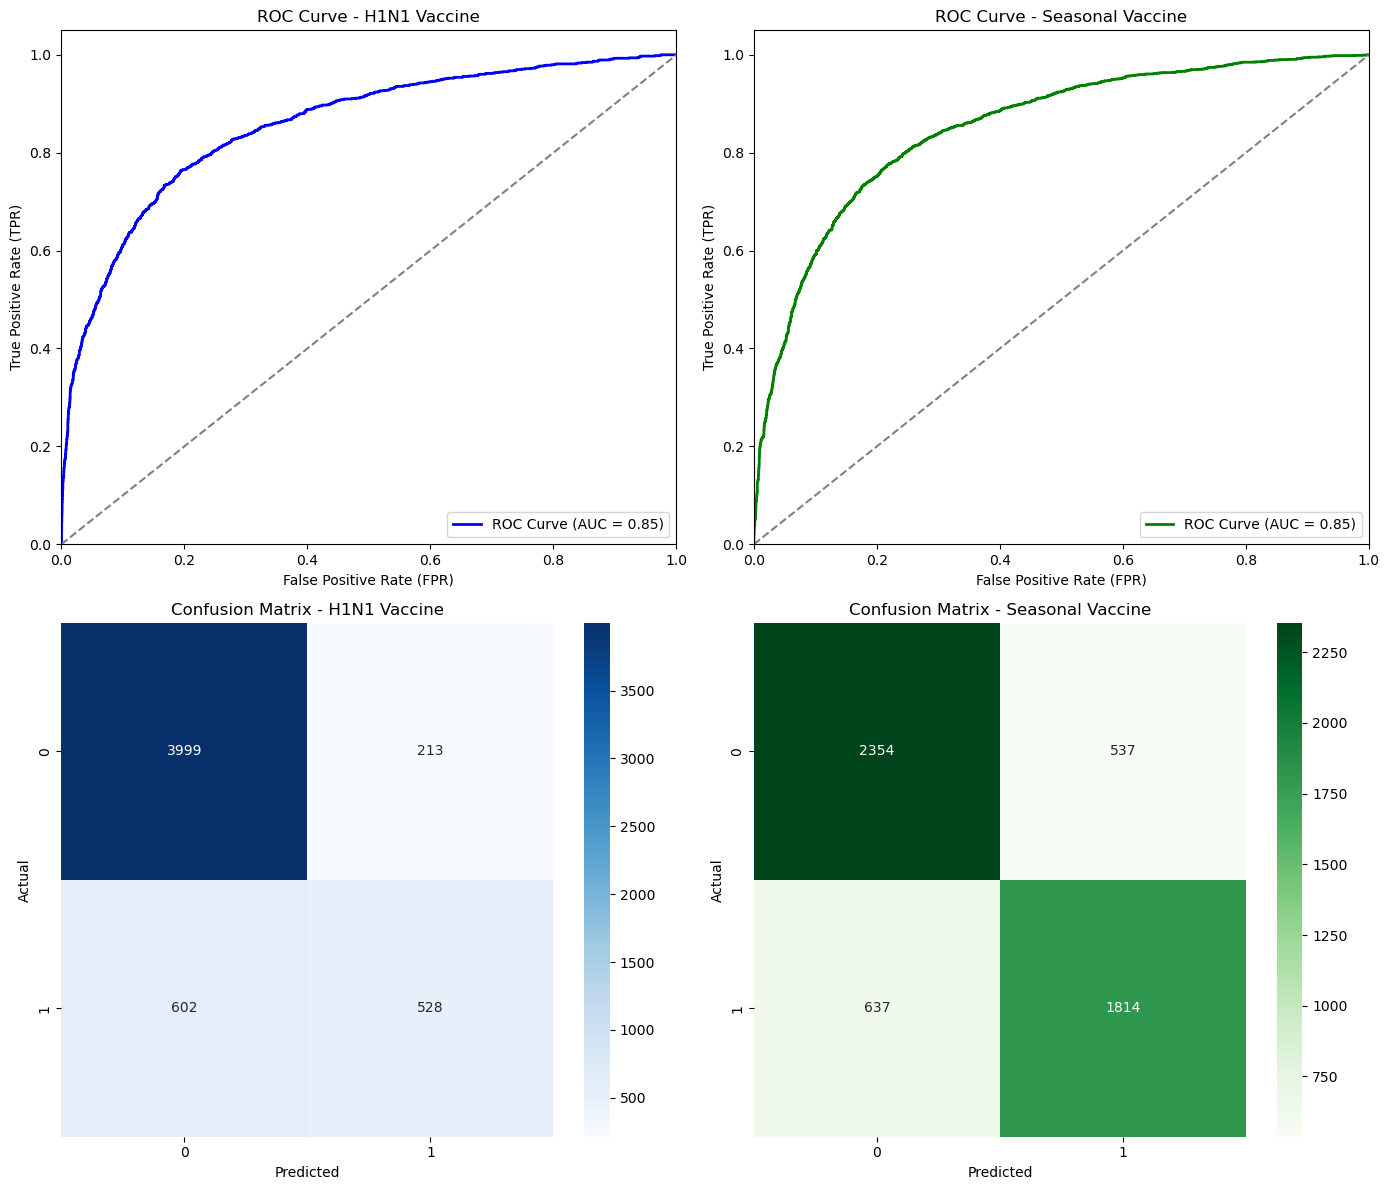

In [ ]:
# Logistic Regression
use_preproccesor = 5
if use_preproccesor == 1:
    display("using 1")
    #results .83 .86
    X_train_log_reg, X_test_log_reg  = preprocess_simple(X_train, X_test)
    y_train_log_reg = y_train.copy()
    y_test_log_reg = y_test.copy()
elif use_preproccesor == 2:
    display("using 2")
    #results .83 .86
    #results with smote .80 .81
    X_train_log_reg, X_test_log_reg, y_train_log_reg, y_test_log_reg = preprocess_train_test2(X_train,X_test,y_train,y_test,use_smote=True)
elif use_preproccesor == 3:
    display("using 3")
    #results .83 .86
    X_train_log_reg, X_test_log_reg, y_train_log_reg, y_test_log_reg = preprocess_train_test3(X_train,X_test,y_train,y_test)
elif use_preproccesor == 4:
    display("using 4")
    #results .85 .84
    X_train_log_reg, X_test_log_reg  = simplest_preprocessor(X_train, X_test)
    y_train_log_reg = y_train.copy()
    y_test_log_reg = y_test.copy()
elif use_preproccesor == 5:
    display("using 5")
    #results .85 .85
    X_train_log_reg, X_test_log_reg  = preprocess_train_test(X_train, X_test)
    y_train_log_reg = y_train.copy()
    y_test_log_reg = y_test.copy()

log_reg = MultiOutputClassifier(LogisticRegression(random_state=42))
log_reg.fit(X_train_log_reg, y_train_log_reg)
y_pred_log_reg_test = log_reg.predict(X_test_log_reg)
y_log_reg_pred_proba = [est.predict_proba(X_test_log_reg) for est in log_reg.estimators_]
summary(y_test_log_reg, y_pred_log_reg_test, y_log_reg_pred_proba)

## SVM

In [ ]:
def final_preprocessor(train_df, test_df, target_train_df, target_test_df, scaler='standard', num_imputer_strategy='median', missing_strat='replace', use_smote=False, use_class_weights=False):
    train_df = train_df.copy()
    test_df = test_df.copy()
    target_train_df = target_train_df.copy()
    target_test_df = target_test_df.copy()
    
    # Collect all defined columns
    all_defined_columns = numeric_cols + binary_cols + encoded_categorical_cols + categorical_cols

    # Assert that all columns are used
    missing_columns = set(train_df.columns) - set(all_defined_columns)
    extra_columns = set(all_defined_columns) - set(train_df.columns)
    
    assert len(missing_columns) == 0, f"Missing columns: {missing_columns}"
    assert len(extra_columns) == 0, f"Extra columns: {extra_columns}"

    if num_imputer_strategy == '-1':
        pass
    else:
        num_imputer_strategy = 'median'

    num_scaler = StandardScaler() if scaler == 'standard' else MinMaxScaler()
    
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_imputer_strategy)),
        ('scaler', num_scaler)
    ])
    
    # Define preprocessing for categorical columns
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])
    
    # Combine preprocessing for numerical and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numeric_cols),
            ('binary', numerical_pipeline, binary_cols),
            ('encoded_cat', numerical_pipeline, encoded_categorical_cols),
            ('cat', categorical_pipeline, categorical_cols)
        ]
    )
    
    # Create and apply the full pipeline
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # Fit and transform the training data
    train_df = full_pipeline.fit_transform(train_df)
    test_df = full_pipeline.transform(test_df)
    
    # Optional: Apply SMOTE
    if use_smote:
        smote = SMOTE(random_state=42)
        train_df, target_train_df = smote.fit_resample(train_df, target_train_df)
    
    return train_df, test_df, target_train_df, target_test_df